In [1]:
!nvidia-smi

Mon May 29 04:52:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Unzipping FFHQ and FakeFaces Dataset 
###FFHQ Dataset to be used as real images, and FakeFaces Dataset as fake images

In [3]:
!unzip '/content/drive/MyDrive/Datasets/Deepfake/FakeFaces.zip' &> /dev/null
!unzip '/content/drive/MyDrive/Datasets/Deepfake/FFHQ Dataset.zip' &> /dev/null

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
!pip install keras_preprocessing &> /dev/null
from keras_preprocessing import image

In [5]:
def load_images_from_folder(folder):
    images = []
    smallest_height = float('inf')
    smallest_width = float('inf')
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = image.load_img(img_path)
        width, height = img.size
        smallest_width = min(smallest_width, width)
        smallest_height = min(smallest_height, height)
        images.append(img_path)
    return images, smallest_height, smallest_width

folder_A = '/content/thumbnails128x128/'  # PATH TO REAL IMAGES
folder_B = '/content/FakeFaces/Fake/'  # PATH TO FAKE IMAGES

images_A, height_A, width_A = load_images_from_folder(folder_A)
images_B, height_B, width_B = load_images_from_folder(folder_B)

# Use the smallest height and width for resizing
resize_height = min(height_A, height_B)
resize_width = min(width_A, width_B)

# Combine the two lists
labels = [0]*len(images_A) + [1]*len(images_B)  # 0 for real, 1 for fake
images = images_A + images_B

# Train-Test-Validation Split (60%-20%-20%)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, stratify=train_labels, random_state=42)  # 0.25 x 0.8 = 0.2

# Now load, resize and convert the images to numpy arrays
def process_images(image_paths, target_size):
    return np.array([image.img_to_array(image.load_img(img, target_size=target_size)) for img in image_paths])

# Convert lists into numpy arrays
train_images = process_images(train_images, (resize_height, resize_width))
test_images = process_images(test_images, (resize_height, resize_width))
val_images = process_images(val_images, (resize_height, resize_width))

# Convert labels into numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

# You now have your train, test and validation datasets in the
# train_images, test_images, val_images, train_labels, test_labels, and val_labels variables


In [6]:
print("Train images size: ", train_images.shape)
print("Test images size: ", test_images.shape)
print("Validation images size: ", val_images.shape)

Train images size:  (45840, 128, 128, 3)
Test images size:  (15280, 128, 128, 3)
Validation images size:  (15280, 128, 128, 3)


In [7]:
!pip install tensorflow-addons &> /dev/null

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow_addons.layers import MultiHeadAttention
from tensorflow.keras.applications import EfficientNetB0

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
def build_model():
    inputs = tf.keras.Input(shape=(128, 128, 3))
    efficient_net = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    x = layers.GlobalAveragePooling2D()(efficient_net.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    return model

model = build_model()
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)     

In [10]:
# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
1433/1433 [==============================] - 127s 51ms/step - loss: 0.0181 - binary_accuracy: 0.9939 - val_loss: 0.3407 - val_binary_accuracy: 0.8711
Epoch 2/10
1433/1433 [==============================] - 69s 48ms/step - loss: 0.0063 - binary_accuracy: 0.9987 - val_loss: 0.0670 - val_binary_accuracy: 0.9202
Epoch 3/10
1433/1433 [==============================] - 69s 48ms/step - loss: 0.0025 - binary_accuracy: 0.9993 - val_loss: 6.6699e-04 - val_binary_accuracy: 0.9997
Epoch 4/10
1433/1433 [==============================] - 69s 48ms/step - loss: 0.0051 - binary_accuracy: 0.9989 - val_loss: 0.0011 - val_binary_accuracy: 0.9995
Epoch 5/10
1433/1433 [==============================] - 68s 48ms/step - loss: 0.0014 - binary_accuracy: 0.9996 - val_loss: 9.2453e-06 - val_binary_accuracy: 1.0000
Epoch 6/10
1433/1433 [==============================] - 68s 48ms/step - loss: 0.0038 - binary_accuracy: 0.9991 - val_loss: 0.0017 - val_binary_accuracy: 0.9995
Epoch 7/10
1433/1433 [=========

In [13]:
# Print the history
print(history.history)

{'loss': [0.018089236691594124, 0.00629295501857996, 0.002485509729012847, 0.005128018092364073, 0.0013734805397689342, 0.003773284610360861, 0.0008708239765837789, 0.0013592677423730493, 0.0017272005788981915, 1.5872916264925152e-05], 'binary_accuracy': [0.9939135909080505, 0.9986692667007446, 0.9993237257003784, 0.9989310503005981, 0.9995855093002319, 0.9991492033004761, 0.9997382164001465, 0.9997164011001587, 0.9996291399002075, 1.0], 'val_loss': [0.3406575620174408, 0.06699128448963165, 0.0006669937865808606, 0.001126624527387321, 9.245253750123084e-06, 0.0017246818169951439, 5.7438370276940987e-05, 2.6654693101590965e-06, 4.58906606581877e-06, 1.910519358716556e-06], 'val_binary_accuracy': [0.871073305606842, 0.9201570749282837, 0.9996727705001831, 0.9995418787002563, 1.0, 0.999476432800293, 0.9999345541000366, 1.0, 1.0, 1.0]}


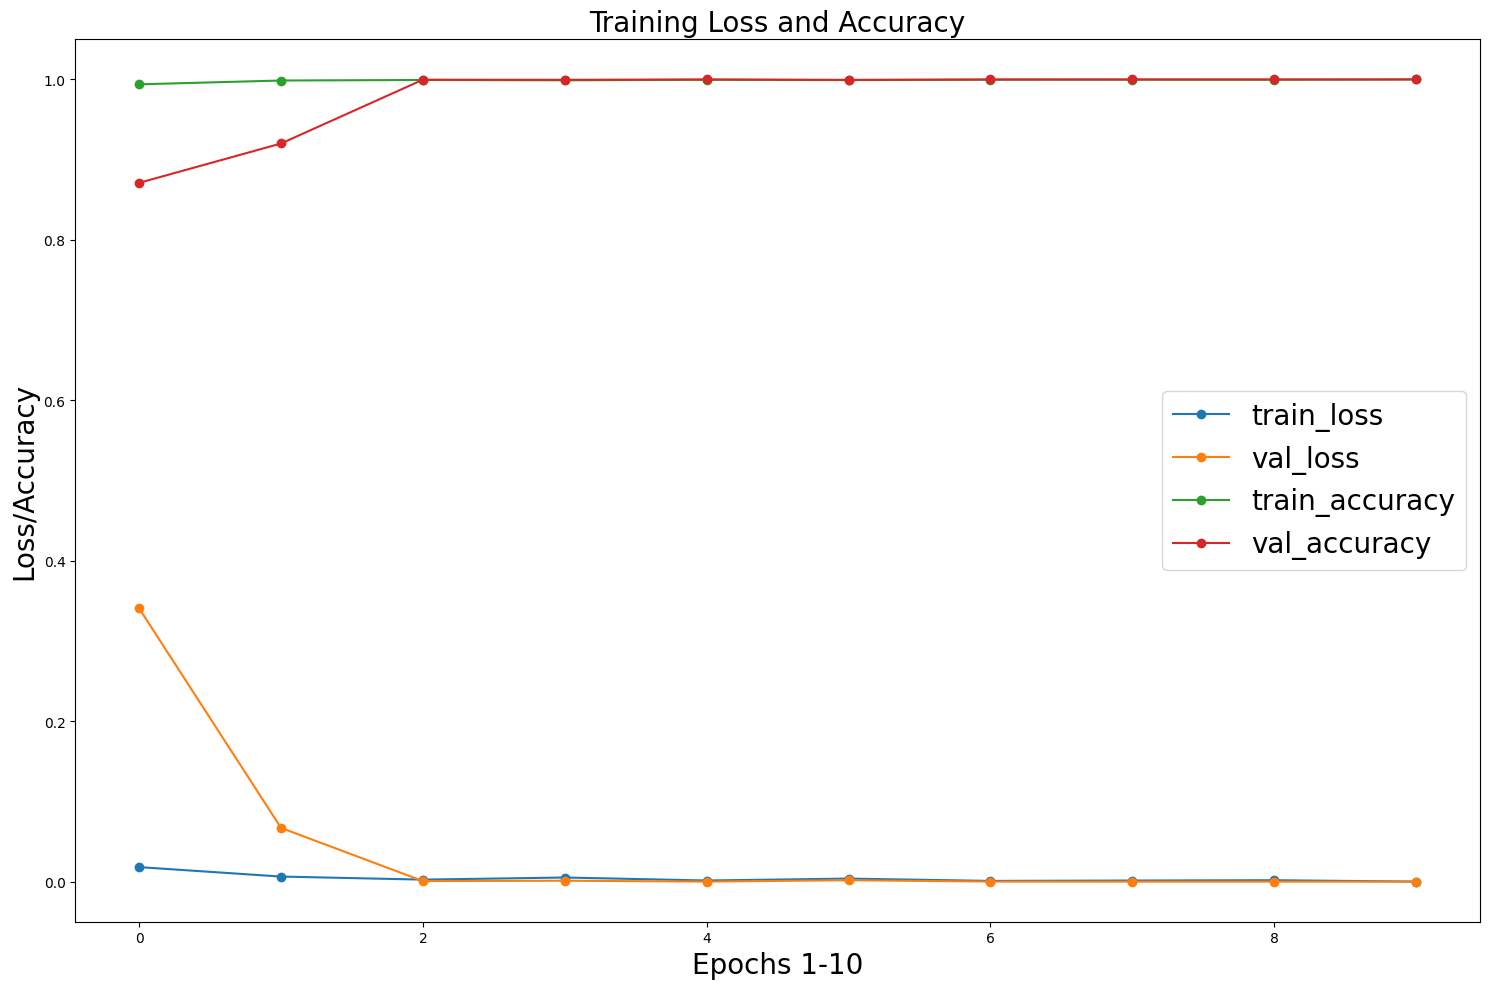

In [17]:
import matplotlib.pyplot as plt
history = history.history
# Plotting
plt.figure(figsize=(15, 10))
plt.plot(range(len(history["loss"])), history["loss"], "-o", label="train_loss")
plt.plot(range(len(history["val_loss"])), history["val_loss"], "-o", label="val_loss")
plt.plot(range(len(history["binary_accuracy"])), history["binary_accuracy"], "-o", label="train_accuracy")
plt.plot(
    range(len(history["val_binary_accuracy"])), history["val_binary_accuracy"], "-o", label="val_accuracy"
)
plt.title("Training Loss and Accuracy", fontdict={'fontsize':20})
#plt.xlabel(f"Epoch {len(history) + 1}", fontsize=20)
plt.xlabel(f"Epochs 1-10", fontsize=20)
plt.ylabel("Loss/Accuracy", fontsize=20)
plt.legend(loc="best", prop={"size": 20})
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(test_images)

y_true = []   # list to store true labels
y_pred = []   # list to store predicted labels

# iterate over the dataset
for image_batch, label_batch in zip(test_images, test_labels):  
    # append true labels
    y_true.append(label_batch)

    # make a prediction
    prediction = model.predict(image_batch)
    y_pred.append(prediction)

# Now y_true and y_pred are filled with the true labels and the predictions

In [25]:
y_pred_labels = [1 if p[0] > 0.5 else 0 for p in y_pred]

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_labels)
print(cm)

[[11218  2782]
 [    2  1278]]


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred_labels, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       1.00      0.80      0.89     14000
     Class 1       0.31      1.00      0.48      1280

    accuracy                           0.82     15280
   macro avg       0.66      0.90      0.68     15280
weighted avg       0.94      0.82      0.86     15280



In [33]:
# Print accuracy
accuracy = accuracy_score(y_true, y_pred_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print precision, recall, and f1 score
precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 81.78%
Precision: 0.31
Recall: 1.00
F1 Score: 0.48


In [34]:
# Print confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png', dpi=300)  # Save the figure with 300 DPI
plt.close()

# Print ROC-AUC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_labels)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc_auc_curve.png', dpi=300)  # Save the figure with 300 DPI
plt.close()